### 1.0 Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import datetime as dt
from math import radians, cos, sin, asin, sqrt #using this for calculating the distance between points

### 2.0 Load Data

Loading in the cleaned, exported data from my data wrangling step.

In [3]:
#load trees data we exported in the prior step
trees_data = pd.read_csv('../data/data_outputs/seattle_trees.csv')

#load climate data we exported in the prior step
climate_data = pd.read_csv('../data/data_outputs/washington_climate_normals.csv')

#### 2.1 Precipitation Data

After testing this out with climate normals data, I only ended up with 3 useful stations for data. So while I was excited to have the 'normals' which is averages over a 15-20 year period, I want to now test pulling in some other data I found.
\
\
The Community Collaborative Rain, Hail, & Snow Network has some great tools to access data. Unfortunately, it is only for the 2022 calendar year. I don't love that, but I think it will give me more useful datapoints to and make the analysis more valuable.
\
\
When pulling this data, I filtered down to all available weather stations in King County, Washington, which includes the Seattle proper.
\
\
https://merbgai.cocorahs.org/Stations/ListStations.aspx

In [4]:
prcp_22 = pd.read_excel('../data/precip_2022.xlsx', sheet_name=0)
print(prcp_22.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB
None


In [5]:
prcp_22.head(3)

,Station Number,Station Name,Daily Precipitation Sum MM,Multi-Day Precipitation mm,Total Precipitation mm,Daily Snow Sum cm,# of Reports,Latitude,Longitude,Multi-Day Overlap Warning
0,WA-KG-3,Lake Forest Park 0.4 W,1111.2,NaN,1111.2,0.0,365,47.763558,-122.293917,NaN
1,WA-KG-4,Renton 3.2 E,149.1,NaN,149.1,0.0,21,47.484508,-122.127169,NaN
2,WA-KG-5,Mercer Island 1.5 NW,1043.4,NaN,1043.4,8.4,365,47.585900,-122.250900,NaN


**Observations**
\
\
The 'Total Precipitation mm' column should be the combination of the dailiy and multi-day column and the field we use. There is no multi-day column for snow, so that will be the column we can use for snow data.
\
\
I will need to confirm latitude & longitude data is complete. I also want to do some renaming of columns to make them a little more straight forward. So far what I've seen from the data, I don't need to worry about the multi-day 'warning', as I believe it is cumulative and not duplicative. I also think I'll convert the cm of snow into mm to match the precipitation. Go metric system!

### 3.0 Explore and Combine Data

The first step I have in mind is creating a field that maps each trees to its nearest weather station from my climate normals data.

#### 3.1 Tie Together The Two Dataframes Using Lat-Lon

##### 3.1.1 Rename Fields

In [6]:
#Need a reminder of my fields
trees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162080 entries, 0 to 162079
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   longitude_coordinate       162080 non-null  float64
 4   latitude_coordinate        162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
dtypes: float64(5), object(5)
memory usage: 12.4+ MB


In [7]:
prcp_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB


In [8]:
#Rename lat-long field in trees data to signify it is from this datasource. I could do this on a merge later, but I like to keep them seperate.
trees_data.rename(columns = {'longitude_coordinate': 'long_trees', 'latitude_coordinate': 'lat_trees'}, inplace=True)
#climate_data.rename(columns = {'LONGITUDE': 'long_climate', 'LATITUDE': 'lat_climate'}, inplace=True) leaving this in place incase I want to incorporate this data again later.

In [9]:
#Now I want to go through the precipitation data and rename the fields to be more Python friendly
prcp_22.rename(columns ={'Station Number': 'station_id', 'Station Name': 'station_name', 'Daily Precipitation Sum MM': 'daily_prcp_mm',
                         'Multi-Day Precipitation mm': 'multi_day_prcp_mm', 'Total Precipitation mm': 'total_prcp_mm',
                         'Daily Snow Sum cm': 'daily_snow_cm', '# of Reports': 'reports_#', 'Latitude': 'lat_prcp',
                         'Longitude': 'long_prcp', 'Multi-Day Overlap Warning': 'md_overlap'}, inplace=True)

#verify the names stuck
prcp_22.columns

Index(['station_id', 'station_name', 'daily_prcp_mm', 'multi_day_prcp_mm',
       'total_prcp_mm', 'daily_snow_cm', 'reports_#', 'lat_prcp', 'long_prcp',
       'md_overlap'],
      dtype='object')

##### 3.1.2 Assign Each Tree Record a Unique ID

I'm thinking in order to map back into our dataframe the closest station, I'll need to do it off a primary key and I'd rather not do that just off the location.

In [10]:

#Assign the key numerically, using the index number +1 (to exclude 0)
trees_data['tree_id'] = trees_data.index+1

In [11]:
#let's also change this to an object
trees_data['tree_id'] = trees_data['tree_id'].astype(object)

In [12]:
#Double check values are unique
trees_data['tree_id'].value_counts()

1         1
108057    1
108050    1
108051    1
108052    1
         ..
54028     1
54029     1
54030     1
54031     1
162080    1
Name: tree_id, Length: 162080, dtype: int64

In [13]:
#double check the id is an object now.
trees_data.dtypes

planted_date                  object
most_recent_observation       object
common_name                   object
long_trees                   float64
lat_trees                    float64
diameter_breast_height_CM    float64
condition                     object
native                        object
age_at_obs                   float64
condition_index              float64
tree_id                       object
dtype: object

##### 3.1.3 Define Functions

In [14]:
def dist_b_points(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees). 
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [15]:
def flag_nearest(lat, long, df2):
    """ 
    Label the closest weather station using the results of the dist_b_points function.
    I want to research and test this more. It seems weird to me that we specify the fields and df in the function, rather than use dynamic inputs.
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = df2.apply(
        lambda row: dist_b_points(lat, long, row['lat_prcp'], row['long_prcp']), axis = 1)
    return df2.loc[distances.idxmin(), 'station_id']

##### 3.1.4 Map the Nearest Station to Each Tree Record

In [16]:
#Using my defined functions to add a field to my trees_data df which will list the ID for the nearest weather station.
trees_data['nearest_station'] = trees_data.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees'],prcp_22), axis=1)

In [17]:
#explore results
trees_data['nearest_station'].value_counts()

 WA-KG-239    16065
 WA-KG-204    12400
 WA-KG-280    11640
 WA-KG-225    11626
 WA-KG-258    11472
 WA-KG-287    10225
 WA-KG-200     9474
 WA-KG-79      8940
 WA-KG-266     8921
 WA-KG-243     8778
 WA-KG-272     8279
 WA-KG-294     6749
 WA-KG-301     6495
 WA-KG-229     4918
 WA-KG-238     4825
 WA-KG-192     4377
 WA-KG-199     4195
 WA-KG-72      2565
 WA-KG-234     2544
 WA-KG-145     2369
 WA-KG-33      1830
 WA-KG-286     1138
 WA-KG-299      796
 WA-KG-297      676
 WA-KG-263      492
 WA-KG-5        236
 WA-KG-81        34
 WA-KG-210       21
Name: nearest_station, dtype: int64

This looks a lot better than the last data source, which only had 3 'nearest' stations. Let's now merge these in and explore a bit more.
##### 3.1.5 Merge Datasets Into a Single Table

In [18]:
#inner join on the station_id to create a master df to continue with my EDA.
trees_prcp_all = pd.merge(trees_data, prcp_22, left_on='nearest_station', right_on='station_id', how='inner')

In [19]:
#check which stations came back, we'll use the station id later to split out for our map
trees_prcp_all[['station_id','station_name']].value_counts()

station_id  station_name            
 WA-KG-239  Seattle 3.9 N               16065
 WA-KG-204  Seattle 0.9 SSE             12400
 WA-KG-280  Seattle 4.6 NNE             11640
 WA-KG-225  Seattle 2.1 ESE             11626
 WA-KG-258  Seattle 6.4 S               11472
 WA-KG-287  Seattle 2.5 SE              10225
 WA-KG-200  Seattle 5.8 SSE              9474
 WA-KG-79   Seattle 3.0 WNW              8940
 WA-KG-266  Seattle 2.9 ENE              8921
 WA-KG-243  Seattle 3.9 SSW              8778
 WA-KG-272  Seattle 4.9 SE               8279
 WA-KG-294  Seattle 4.0 NNW              6749
 WA-KG-301  Seattle 4.8 NNW              6495
 WA-KG-229  Seattle 5.5 NNE              4918
 WA-KG-238  Seattle 5.0 NE               4825
 WA-KG-192  Seattle 5.6 N                4377
 WA-KG-199  Seattle 4.5 N                4195
 WA-KG-72   Seattle 4.2 SW               2565
 WA-KG-234  Matthews Beach 0.4 NW        2544
 WA-KG-145  Seattle 4.2 N                2369
 WA-KG-33   Sheridan Beach 3.7 S         18

In [20]:
#Check how manyunique values of nearest station
len(trees_prcp_all['nearest_station'].unique())

28

##### 3.1.6 Validate Visually

I want to plot both the stations an the trees on the same plot/map to see if these make sense visually.

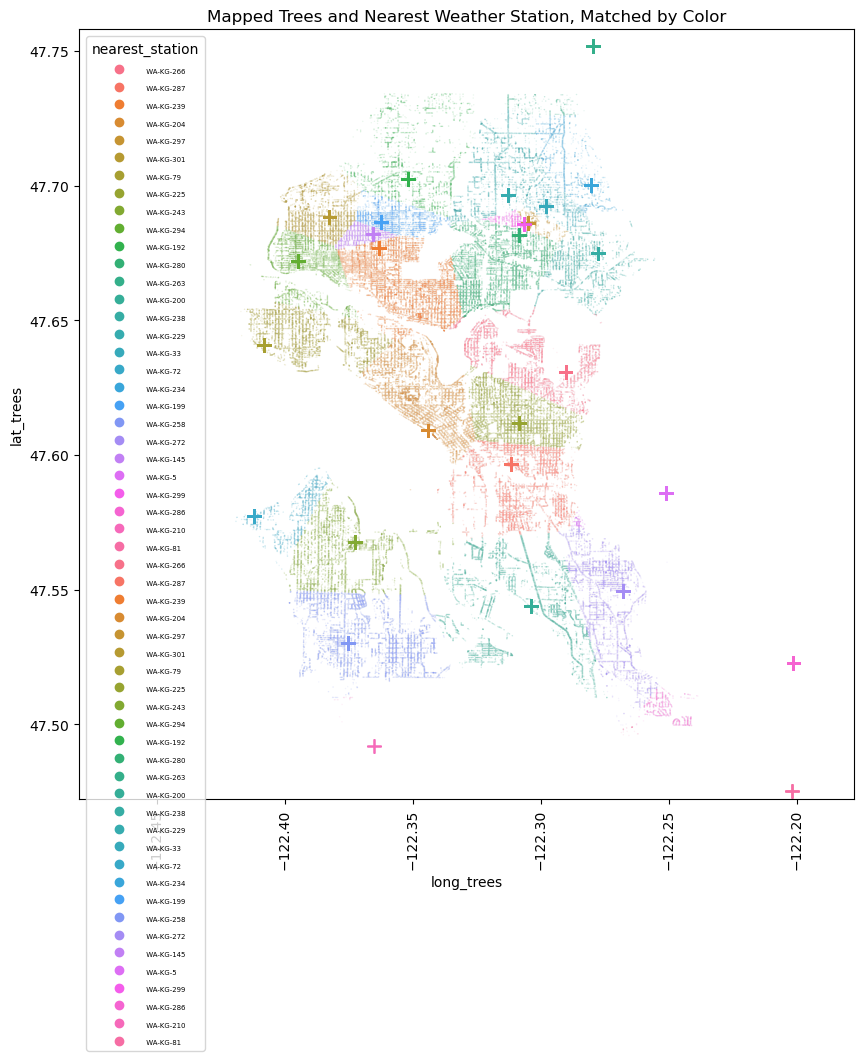

In [21]:
#Create a plot, splitting out the different points by color for their different closest stations and plot them on the same plane as the stations.
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(ax=ax, x='long_trees', y='lat_trees', data=trees_prcp_all, hue='nearest_station', marker='o', s=1, alpha=0.1)
sns.scatterplot(ax=ax, x='long_prcp', y='lat_prcp', data=trees_prcp_all, hue='nearest_station', marker='+', s=100)

#zoom into rough seattle area by adding some space around the min and max values
plt.axis([trees_data['long_trees'].min()*1.0005, trees_data['long_trees'].max()*.9995, trees_data['lat_trees'].min()*0.9995, trees_data['lat_trees'].max()*1.0005])

#set title, change legend font size, and rotate axis labels
ax.set_title('Mapped Trees and Nearest Weather Station, Matched by Color')
plt.setp(ax.get_legend().get_texts(), fontsize='5')
plt.xticks(rotation=90)
plt.show()

**Observations**
\
This isn't the prettiest graph, which such a long legend and no actual underlying map, but it does what I needed and shows the mapping function did work to flag the closest weather station to each tree. There are some some tree-station pair groupings, with the smallest being 26 tree records mapping closest to Burien 2.1 NNW station, I will let these play out as I do more EDA.
\
\
A next question I have is the location to the nearest station. I see some station '+' markers pretty isolated. They may still be the 'closest' but aren't close enough to be fully valuable. We can add another field with distance to the nearest station before moving on to the rest of our more 'traditional' EDA. This will give our data another variable that could prove useful.

##### 3.1.7 Distance Between Points

In [22]:
# Use our handy formula created above on our trees_prcp_all df using list comprehension on each row. This could be a lenghty run so let's see how it goes.

trees_prcp_all['distance_between'] = [dist_b_points(trees_prcp_all.long_trees[i], trees_prcp_all.lat_trees[i]
                                                    , trees_prcp_all.long_prcp[i], trees_prcp_all.lat_prcp[i]) 
                                                    for i in range(len(trees_prcp_all))]

In [23]:
#That actually ran really fast. Let's see how it went.
trees_prcp_all['distance_between'].describe()

count    162080.000000
mean          1.517032
std           0.977325
min           0.004214
25%           0.807316
50%           1.334919
75%           1.988311
max           7.514261
Name: distance_between, dtype: float64

It is a little hard to tell without mapping out a full map, but I know a quarter degree of longitude is around 8.5 miles. Looking at our plot above this appears plausible that the max disstance would be around 7.5km.

In [24]:
#Let's see how that looks in our df
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,station_name,daily_prcp_mm,multi_day_prcp_mm,total_prcp_mm,daily_snow_cm,reports_#,lat_prcp,long_prcp,md_overlap,distance_between
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,Seattle 2.9 ENE,680.0,NaN,680.0,0.0,237,47.630883,-122.290286,NaN,0.947927
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,Seattle 2.9 ENE,680.0,NaN,680.0,0.0,237,47.630883,-122.290286,NaN,3.367105
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,Seattle 2.9 ENE,680.0,NaN,680.0,0.0,237,47.630883,-122.290286,NaN,1.145690


### 3.2 "Traditional" EDA

Now that we have a combined dataframe, let's move on to exploring it further with some fun EDA.

#### 3.2.1 Shape

We've done a lot of work on this, so let's get a reminder of the shape.

In [25]:
trees_prcp_all.shape

(162080, 23)

We're up to 23 fields, and still have all our 160k tree records. Let's keep going.

#### 3.2.2 Data Types and Column Info

In [26]:
trees_prcp_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162080 entries, 0 to 162079
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   long_trees                 162080 non-null  float64
 4   lat_trees                  162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
 10  tree_id                    162080 non-null  object 
 11  nearest_station            162080 non-null  object 
 12  station_id                 162080 non-null  object 
 13  station_name               16

We have some missing values in planted_date, most_recent_observation, age_at_obs (expected as this was calculated of the prior two), multi-day_prcp_mm, and md_overlap.
\
\
I feel like we will want to impute values for missing ages later and I want to explore the daily vs. multi-day preceiptation a little more later in this notebook. But first let's update some data types!

In [27]:
#We need to update our data fields to be datetime dtypes
trees_prcp_all['planted_date'] = pd.to_datetime(trees_prcp_all['planted_date'])
trees_prcp_all['most_recent_observation'] = pd.to_datetime(trees_prcp_all['most_recent_observation'])

trees_prcp_all[['planted_date','most_recent_observation']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162080 entries, 0 to 162079
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   planted_date             159111 non-null  datetime64[ns]
 1   most_recent_observation  162075 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.7 MB


#### 3.2.3 Check Missing Values %

In [28]:
#I did this in my initial data wrangling, but not since adding fields. I like this formula better as well.
trees_prcp_all.isnull().sum() / trees_prcp_all.shape[0] * 100

planted_date                  1.831811
most_recent_observation       0.003085
common_name                   0.414610
long_trees                    0.000000
lat_trees                     0.000000
diameter_breast_height_CM     0.000000
condition                     0.000000
native                        0.000000
age_at_obs                    1.834896
condition_index               0.000000
tree_id                       0.000000
nearest_station               0.000000
station_id                    0.000000
station_name                  0.000000
daily_prcp_mm                 0.000000
multi_day_prcp_mm            17.705454
total_prcp_mm                 0.000000
daily_snow_cm                 0.000000
reports_#                     0.000000
lat_prcp                      0.000000
long_prcp                     0.000000
md_overlap                   88.991239
distance_between              0.000000
dtype: float64

Like we called out before, the date age was expected and the multi-day fields still stick out. Let's deal with those, and see if we even need to keep them. To feel comfortable with these fields, I want to check if the daily + multi-day = total precipitation

#### 3.2.4 Deal with Missing Multi-Day Precipitation Values

##### 3.2.4.1 Validate The Parts Equal the Whole

In [29]:
# Store fund columns to sum against
prcp_columns = ['daily_prcp_mm', 'multi_day_prcp_mm']

# Find rows where prcp_columns row sum == inv_amount
prcp_equ = trees_prcp_all[prcp_columns].sum(axis=1) == trees_prcp_all['total_prcp_mm']

# Store consistent and inconsistent data
consistent_prcp = trees_prcp_all[prcp_equ]
inconsistent_prcp = trees_prcp_all[~prcp_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_prcp.shape[0])

Number of inconsistent investments:  38234


In [30]:
#What do those records look like? I'm going to look by unique station
inconsistent_prcp[['station_name','daily_prcp_mm','multi_day_prcp_mm','total_prcp_mm']].value_counts()

station_name          daily_prcp_mm  multi_day_prcp_mm  total_prcp_mm
Seattle 4.6 NNE       179.1          265.7              444.8            11640
Seattle 4.9 SE        913.1          29.2               942.3             8279
Seattle 4.0 NNW       418.1          3.8                421.9             6749
Seattle 4.8 NNW       308.4          96.8               405.1             6495
Seattle 4.2 SW        931.7          98.6               1030.2            2565
Sheridan Beach 3.7 S  957.8          37.3               995.2             1830
Seattle 4.9 NNE       220.0          232.2              452.1              676
dtype: int64

The stations above don't tie according to the calculations, but it appears to be just rounding as each either matches to 1 decimal or is off by just 0.1 mm. To be safe, I will add a new calculated field and drop the rest.

##### 3.2.4.2 Create Calculated Field

In [31]:
#Create a new field using daily + multi-day. I'm also filling NaNs with 0 on the multi day in order to add correctly.
trees_prcp_all['prcp_mm_22'] = trees_prcp_all['daily_prcp_mm'] + trees_prcp_all['multi_day_prcp_mm'].fillna(0)

#np.where(df['Set']=='Z', 'green', 'red')

In [32]:
#Simplified looking using value counts on subset of data to see how each station looks
trees_prcp_all[['station_name','daily_prcp_mm','multi_day_prcp_mm','total_prcp_mm','prcp_mm_22']].value_counts()

station_name           daily_prcp_mm  multi_day_prcp_mm  total_prcp_mm  prcp_mm_22
Seattle 3.9 N          908.6          75.9               984.5          984.5         16065
Seattle 0.9 SSE        804.9          134.9              939.8          939.8         12400
Seattle 4.6 NNE        179.1          265.7              444.8          444.8         11640
Seattle 2.1 ESE        1081.8         35.8               1117.6         1117.6        11626
Seattle 6.4 S          972.8          165.4              1138.2         1138.2        11472
Seattle 2.5 SE         603.0          535.7              1138.7         1138.7        10225
Seattle 3.0 WNW        637.5          1.3                638.8          638.8          8940
Seattle 4.9 SE         913.1          29.2               942.3          942.3          8279
Seattle 4.0 NNW        418.1          3.8                421.9          421.9          6749
Seattle 4.8 NNW        308.4          96.8               405.1          405.2          64

In [33]:
#how about the fields that had the multi-day NaN?
trees_prcp_all[trees_prcp_all['multi_day_prcp_mm'].isna()][['total_prcp_mm','prcp_mm_22']].value_counts()

total_prcp_mm  prcp_mm_22
669.3          669.3         9474
680.0          680.0         8921
0.0            0.0           8778
369.3          369.3          796
1032.0         1032.0         492
1043.4         1043.4         236
dtype: int64

The few that didn't match, now do (even if it may have just been some rounding). And the ones with no multi-day data are consistent, so now I will drop the other prcp columns.

##### 3.2.4.3 Drop Other Fields

In [34]:
#I will drop all prcp related fields
trees_climate = trees_prcp_all.drop(columns=['daily_prcp_mm','multi_day_prcp_mm','total_prcp_mm','md_overlap'])

trees_climate.shape

(162080, 20)

#### 3.2.5 Cleanup Remaining Climate Data

The last two things on my mind with this climate data is converting cm to mm and figuring out whether the # of reports field will be of any use.

##### 3.2.5.1 Convert Snow Fall to mm

In [35]:
#Since the metric system is the best, I can easily create a new mm field for snow by multiplying my cm by 10.
trees_climate['daily_snow_mm'] = trees_climate['daily_snow_cm']*10

In [36]:
#I will check a the same value count look as before with at each station but with these two fields
trees_climate[['station_name','daily_snow_cm','daily_snow_mm']].value_counts()

station_name              daily_snow_cm  daily_snow_mm
Seattle 3.9 N             0.0            0.0              16065
Seattle 0.9 SSE           0.0            0.0              12400
Seattle 4.6 NNE           0.0            0.0              11640
Seattle 2.1 ESE           19.6           196.0            11626
Seattle 6.4 S             3.8            38.0             11472
Seattle 2.5 SE            3.5            35.0             10225
Seattle 5.8 SSE           0.8            8.0               9474
Seattle 3.0 WNW           1.3            13.0              8940
Seattle 2.9 ENE           0.0            0.0               8921
Seattle 3.9 SSW           4.8            48.0              8778
Seattle 4.9 SE            0.0            0.0               8279
Seattle 4.0 NNW           0.0            0.0               6749
Seattle 4.8 NNW           0.0            0.0               6495
Seattle 5.5 NNE           0.0            0.0               4918
Seattle 5.0 NE            2.5            25.0    

In [37]:
#Now we will drop the original cm field
trees_climate.drop(columns=['daily_snow_cm'],inplace=True)

In [38]:
#verify the column was dropped
trees_climate.shape

(162080, 20)

That looks good, so now let's explore the # of reports field to see if there will be any use for it.

#### 3.2.6 # of Reports Field

In [39]:
trees_climate[['station_id','station_name','reports_#','prcp_mm_22','daily_snow_mm']].value_counts()

station_id  station_name              reports_#  prcp_mm_22  daily_snow_mm
 WA-KG-239  Seattle 3.9 N             317        984.5       0.0              16065
 WA-KG-204  Seattle 0.9 SSE           314        939.8       0.0              12400
 WA-KG-280  Seattle 4.6 NNE           50         444.8       0.0              11640
 WA-KG-225  Seattle 2.1 ESE           356        1117.6      196.0            11626
 WA-KG-258  Seattle 6.4 S             337        1138.2      38.0             11472
 WA-KG-287  Seattle 2.5 SE            236        1138.7      35.0             10225
 WA-KG-200  Seattle 5.8 SSE           290        669.3       8.0               9474
 WA-KG-79   Seattle 3.0 WNW           224        638.8       13.0              8940
 WA-KG-266  Seattle 2.9 ENE           237        680.0       0.0               8921
 WA-KG-243  Seattle 3.9 SSW           3          0.0         48.0              8778
 WA-KG-272  Seattle 4.9 SE            300        942.3       0.0               8279
 

**Observations**

Unfortunately, looking at the documentation from the data source, this data relies on collaborative data entry and the reports_# field actually signifies the number of days for which there was data entered. This is further complicated by the fact that multi-day reports only are counted for 1 day of reporting. As an example of this, WA-KG-225 has a full 365 days of data. But 9 of the days were entered in a multi-day batch, so it shows as having only 356 reports.
\
\
I don't love this, and it comes back to me not being able to find a solid data source with long-term, complete data. I think it poses a fun and interesting challenge on how to impute information to make this data useable. My initial thoughts are to use a few of the more complete stations, calculate some "normals" on daily averages, and use them to beef up the others stations's data. This won't be perfect because I won't know which time of year has missing data (rainy or dry season?), but it wil have to do!

### 3.3 Normalize Climate Data For Missing Observations

I want to set aside the complete stations, get their averages, and then map those to the nearest stations missing data. I was able to manually check a few of the more complete stations and feel the ones with at least 300 obervastion are pretty complete and could be used to create averages.

#### 3.3.1 Calculate Average on Most Complete Stations

In [40]:
#We need to estimate how many reports aren't counted due to having multi-day reporting. We'll assume 4% of days were multi-day reports, so we'll need a conditional statement to add days to the denominator.
#This 4% is an esimate based on looking at a few of the station's daily details.

trees_climate['adj_reports'] = round(trees_climate['reports_#']*1.04,0).astype(int) #create a field with reports *1.05 for my 5% adj factor
trees_climate['max_reports'] = 365 #create a field with the max possible days to then choose the proper adjusted days
trees_climate['adj_reports'] = trees_climate[['adj_reports','max_reports']].min(axis=1) #update adj_reports to be the lessor of 105% adj or 365 max
trees_climate.drop(columns=['max_reports'],inplace=True) #drop the now unecessary max column

#let's check it out
trees_climate.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,nearest_station,station_id,station_name,reports_#,lat_prcp,long_prcp,distance_between,prcp_mm_22,daily_snow_mm,adj_reports
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,237,47.630883,-122.290286,0.947927,680.0,0.0,246
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,237,47.630883,-122.290286,3.367105,680.0,0.0,246
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,237,47.630883,-122.290286,1.145690,680.0,0.0,246


In [41]:
#subset my earlier 2022 prcp dataframe to only those with 300 observations or more and drop duplicates.
prcp_subset = trees_climate[trees_climate['reports_#'] >= 300][['station_id','station_name','lat_prcp','long_prcp','reports_#','adj_reports','prcp_mm_22','daily_snow_mm']].drop_duplicates('station_id', keep='first')

prcp_subset.shape

(12, 8)

In [42]:
#validate distinct data
prcp_subset

,station_id,station_name,lat_prcp,long_prcp,reports_#,adj_reports,prcp_mm_22,daily_snow_mm
19146,WA-KG-239,Seattle 3.9 N,47.676830,-122.363210,317,330,984.5,0.0
35211,WA-KG-204,Seattle 0.9 SSE,47.609077,-122.343988,314,327,939.8,0.0
63722,WA-KG-225,Seattle 2.1 ESE,47.611700,-122.308500,356,365,1117.6,196.0
116858,WA-KG-238,Seattle 5.0 NE,47.674780,-122.277570,330,343,1029.7,25.0
121683,WA-KG-229,Seattle 5.5 NNE,47.696532,-122.312907,329,342,1087.1,0.0
126601,WA-KG-33,Sheridan Beach 3.7 S,47.692402,-122.298027,353,365,995.1,104.0
128431,WA-KG-72,Seattle 4.2 SW,47.577384,-122.412039,342,356,1030.3,51.0
130996,WA-KG-234,Matthews Beach 0.4 NW,47.700155,-122.280497,328,341,1045.0,0.0
137735,WA-KG-258,Seattle 6.4 S,47.530020,-122.375189,337,350,1138.2,38.0
149207,WA-KG-272,Seattle 4.9 SE,47.549338,-122.267714,300,312,942.3,0.0


In [43]:
#Now let's calculate daily averages
prcp_subset['norm_prcp_daily_avg'] = prcp_subset['prcp_mm_22'] / prcp_subset['adj_reports'] #using 'norm_' to signify these are more normalized numbers
prcp_subset['norm_snow_daily_avg'] = prcp_subset['daily_snow_mm'] / prcp_subset['adj_reports'] #using 'norm_' to signify these are more normalized numbers

prcp_subset.head(3)

,station_id,station_name,lat_prcp,long_prcp,reports_#,adj_reports,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg
19146,WA-KG-239,Seattle 3.9 N,47.676830,-122.363210,317,330,984.5,0.0,2.983333,0.000000
35211,WA-KG-204,Seattle 0.9 SSE,47.609077,-122.343988,314,327,939.8,0.0,2.874006,0.000000
63722,WA-KG-225,Seattle 2.1 ESE,47.611700,-122.308500,356,365,1117.6,196.0,3.061918,0.536986


In [44]:
#I'll also rename a few columns to make the merge a bit easier to follow, again using the norm_ flag
prcp_subset.rename(columns = {'station_name':'norm_station_name'}, inplace=True)

#validate
prcp_subset.columns

Index(['station_id', 'norm_station_name', 'lat_prcp', 'long_prcp', 'reports_#',
       'adj_reports', 'prcp_mm_22', 'daily_snow_mm', 'norm_prcp_daily_avg',
       'norm_snow_daily_avg'],
      dtype='object')

#### 3.3.2 Map Each Record to It's Nearest "Complete" Station

For this step, we will reuse the functions used earlier to map each tree, but this time to only this subset of more complete data.

In [45]:
#Using my defined functions to add another field to pull in the ID from the nearest "complete" station
trees_climate['nearest_complete'] = trees_climate.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees'],prcp_subset), axis=1)

In [46]:
#merge in our new "complete" daily averages that we will then use to fill in the gaps
trees_climate = pd.merge(trees_climate, prcp_subset[['station_id','norm_station_name','norm_prcp_daily_avg','norm_snow_daily_avg']], left_on='nearest_complete', right_on='station_id', how='inner', suffixes=('','_norm'))

trees_climate.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,long_prcp,distance_between,prcp_mm_22,daily_snow_mm,adj_reports,nearest_complete,station_id_norm,norm_station_name,norm_prcp_daily_avg,norm_snow_daily_avg
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,-122.290286,0.947927,680.0,0.0,246,WA-KG-225,WA-KG-225,Seattle 2.1 ESE,3.061918,0.536986
1,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,-122.290286,1.145690,680.0,0.0,246,WA-KG-225,WA-KG-225,Seattle 2.1 ESE,3.061918,0.536986
2,1991-07-17,2019-04-27,Carriere (lavallei) hawthorn,-122.281439,47.630559,38.10,good,no_info,27.778804,4.0,...,-122.290286,0.983885,680.0,0.0,246,WA-KG-225,WA-KG-225,Seattle 2.1 ESE,3.061918,0.536986


#### 3.3.3 Calculate New Total Precipitation & Snow Fields, Filling for Missing Days

In [47]:
#fill in missing days with daily avg prcp from our nearest "complete" station
#Adding a 25% adjustment factor due to the thinking that people are more likely to report on days it's raining than not. So assuming a pure daily average for missing days would be overstating the rainfall.
trees_climate['norm_prcp_mm_total'] = trees_climate['prcp_mm_22'] + ((365-trees_climate['adj_reports'])*trees_climate['norm_prcp_daily_avg']*0.75)

#fill in missing days with daily avg prcp from our nearest "complete" station
#but since snow can be very elevation base, let's only imput values if the original records include snow as well. To do this I'll use np.where to make it coniditonal.
#Adding a 25% adjustment factor due to the thinking that people are more likely to report on days it's snowing than not. So assuming a pure daily average for missing days would be overstating the snow.
trees_climate['norm_snow_mm_total'] = np.where(trees_climate['daily_snow_mm'] > 0, trees_climate['daily_snow_mm'] + ((365-trees_climate['adj_reports'])*trees_climate['norm_snow_daily_avg']*0.75), trees_climate['daily_snow_mm'])

In [48]:
#check this with a random sample.
trees_climate.sample(5, replace=False)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,prcp_mm_22,daily_snow_mm,adj_reports,nearest_complete,station_id_norm,norm_station_name,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
139766,1992-09-21,2019-04-27,Fraser's photinia,-122.418664,47.576799,2.54,good,introduced,26.596029,4.0,...,1030.3,51.0,356,WA-KG-72,WA-KG-72,Seattle 4.2 SW,2.894101,0.143258,1049.835183,51.966994
135394,1992-10-30,2019-04-27,Blireiana purpleleaf plum,-122.390928,47.560727,15.24,good,no_info,26.489250,4.0,...,0.0,48.0,3,WA-KG-72,WA-KG-72,Seattle 4.2 SW,2.894101,0.143258,785.748455,86.894663
43472,2005-01-01,2019-04-27,Thundercloud purpleleaf plum,-122.346620,47.658364,25.40,fair,introduced,14.316516,3.0,...,984.5,0.0,330,WA-KG-239,WA-KG-239,Seattle 3.9 N,2.983333,0.000000,1062.812500,0.000000
54555,2015-02-02,2019-04-27,Greencolumn black sugar maple,-122.371213,47.696976,7.62,dead/dying,introduced,4.230066,1.0,...,405.2,0.0,54,WA-KG-239,WA-KG-239,Seattle 3.9 N,2.983333,0.000000,1101.062500,0.000000
57959,1991-09-06,2019-04-27,Purpleleaf plum variety,-122.375335,47.696916,38.10,good,introduced,27.639171,4.0,...,405.2,0.0,54,WA-KG-239,WA-KG-239,Seattle 3.9 N,2.983333,0.000000,1101.062500,0.000000


In [49]:
#spotcheck with value counts
trees_climate[['station_id','adj_reports','station_id_norm','prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].sample(5,replace=False).value_counts()

station_id  adj_reports  station_id_norm  prcp_mm_22  daily_snow_mm  norm_prcp_daily_avg  norm_snow_daily_avg  norm_prcp_mm_total  norm_snow_mm_total
 WA-KG-200  302           WA-KG-272       669.3       8.0            3.020192             0.000000             812.004087          8.000000              1
 WA-KG-204  327           WA-KG-204       939.8       0.0            2.874006             0.000000             1021.709174         0.000000              1
 WA-KG-234  341           WA-KG-234       1045.0      0.0            3.064516             0.000000             1100.161290         0.000000              1
 WA-KG-238  343           WA-KG-238       1029.7      25.0           3.002041             0.072886             1079.233673         26.202624             1
 WA-KG-294  224           WA-KG-239       421.9       0.0            2.983333             0.000000             737.387500          0.000000              1
dtype: int64

**Observations**
\
The math checks out, we'll get into the distributions more later to see if the imputation itself works on a broad scale or if we need to target certain areas specifically.

### 3.4 Back to Traditional EDA. Woohoo!

#### 3.4.1 Check for Duplicates

Duplicates may be realistic if two trees are planted next to eachother on the same date, but let's see if we find any.

In [50]:
duplicates = trees_climate.duplicated()
duplicated_records = trees_climate[duplicates].sort_values('tree_id')

duplicated_records

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,prcp_mm_22,daily_snow_mm,adj_reports,nearest_complete,station_id_norm,norm_station_name,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total


Nice! No exact duplicates

#### 3.4.2 Visualize Distributions

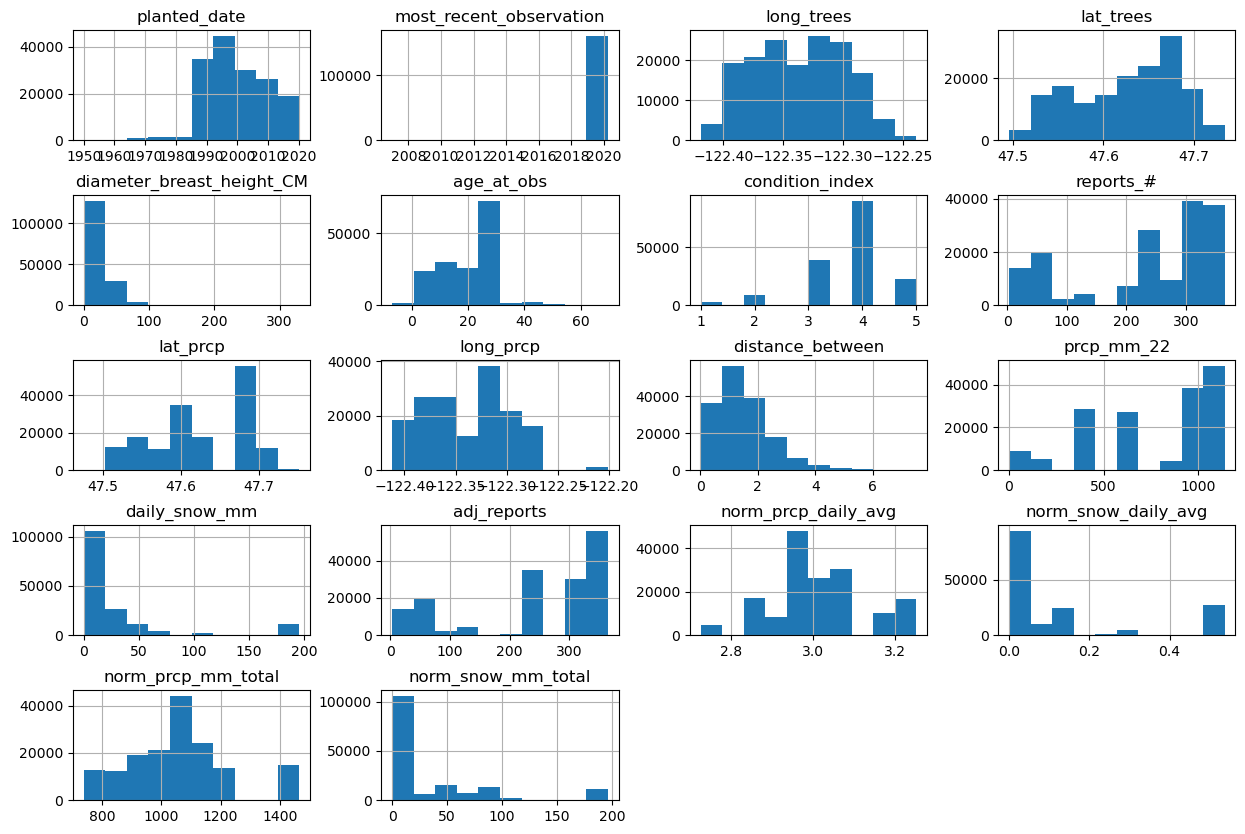

In [51]:
#Histograms
trees_climate.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

**Observations:**
- Planted_date: There is a big jump in the 90s. It's possible there is an older section of the city that wasn't mapped with tree records, but the plot of trees looked pretty widely spread and the lat, lon above fits with the general area of the city. So for now I won't do anything.
- Diameter_breast_height_cm: There is likely a large record out to the right, so we'll need to check that out.
- Condition_index: Not many 1s and 2s. I'll be curious how that plays out in our model.
- Reports_# & Adj_reports: More shifted into that complete 365 window, making me think a lot of our trees are in the area that was just a few short.
- Distance_between: Most of are trees were fairly close to our nearest station data point.
- Precipitation Fields: There are two bins above that 1,250 that really jump out. I'll neet to explore our normalized calculation to see if anything jumps out.
- Snow Fields: There is some large numbers out there, so I'll need to explore that same normalization amount.

#### 3.4.3 Explore Diameter Field

It looks like there may be some outliers here.

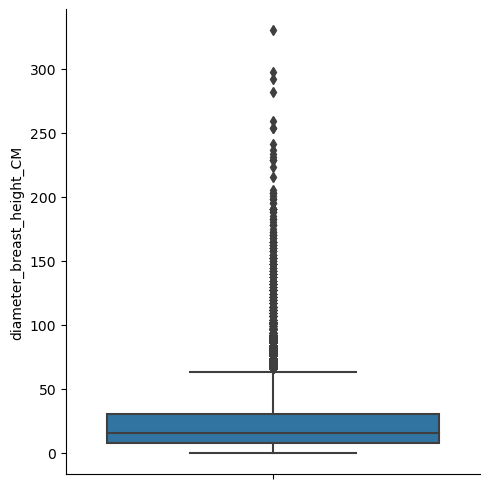

count    162080.000000
mean         21.514417
std          18.640934
min           0.000000
25%           7.620000
50%          15.240000
75%          30.480000
max         330.200000
Name: diameter_breast_height_CM, dtype: float64


In [52]:
#Visualize the data with a boxplot
sns.catplot(y="diameter_breast_height_CM", data=trees_climate, kind="box")

plt.show()

print(trees_climate['diameter_breast_height_CM'].describe())

In [53]:
#filter down to values > 1.5x the IQR
outliers = trees_climate[trees_climate['diameter_breast_height_CM'] > 30.48*1.5]

#display largest value of each tree
outliers.groupby('common_name').max('diameter_breast_height_CM').sort_values('diameter_breast_height_CM', ascending=False)['diameter_breast_height_CM']

common_name
Quaking aspen                       330.20
Giant sequoia                       297.18
Portugal laurel                     292.10
Bigleaf maple                       259.08
Port orford cedar lawson cypress    254.00
                                     ...  
Tatarian maple                       48.26
Swamp white oak                      48.26
Smooth sumac                         48.26
Sterling linden                      48.26
Autumn gold ginkgo                   48.26
Name: diameter_breast_height_CM, Length: 326, dtype: float64

In [54]:
#display average value of each tree
outliers.groupby('common_name').mean('diameter_breast_height_CM').sort_values('diameter_breast_height_CM', ascending=False)['diameter_breast_height_CM']

common_name
Chinese elm                       127.846667
Common lilac                      127.000000
Coast redwood                     124.565833
Pyramidal (bolleana) white pop    124.460000
Portugal laurel                   120.015000
                                     ...    
Sterling linden                    48.260000
Swamp white oak                    48.260000
Cutleaf hornbeam                   48.260000
Tatarian maple                     48.260000
Downy birch                        48.260000
Name: diameter_breast_height_CM, Length: 326, dtype: float64

Breast height diameter is simply the diameter of the tree (width) at breast height. Not specifically the trunk, but reach of the tree. There are some larger values, but the one that surprises me is the quaking aspen. Which generally doesn't reach outward until a way up the trunk. Let's plot that tree specifically.

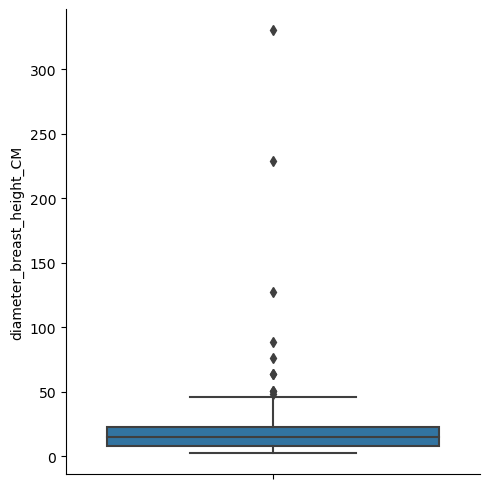

count    298.000000
mean      19.552886
std       25.928508
min        2.540000
25%        7.620000
50%       15.240000
75%       22.860000
max      330.200000
Name: diameter_breast_height_CM, dtype: float64


In [55]:
#Visualize the data with a boxplot
sns.catplot(y="diameter_breast_height_CM", data=trees_climate[trees_climate['common_name'] == 'Quaking aspen'], kind="box")

plt.show()

print(trees_climate[trees_climate['common_name'] == 'Quaking aspen']['diameter_breast_height_CM'].describe())

In [56]:
#There are a some "outliers" but the ones over 100cm are over 3 times the average diameter of aspen trees. I will drop these records.

#Flag the 3 outliers > 100cm, by going through each row and only marking those 3 as "TRUE"
aspen_outliers = (trees_climate['common_name'] == 'Quaking aspen') & (trees_climate['diameter_breast_height_CM'] > 100.0)

aspen_outliers

0         False
1         False
2         False
3         False
4         False
          ...  
162075    False
162076    False
162077    False
162078    False
162079    False
Length: 162080, dtype: bool

In [57]:
#Feed the data back through and set the trees_climate df to only include records that aren't those 3 outliers.
#Print the before and after shape to validate
print(trees_climate.shape)
trees_climate = trees_climate[~aspen_outliers]
print(trees_climate.shape)

(162080, 28)
(162077, 28)


#### 3.4.4 Validate Normalized/Imputed Precipitation and Snow Numbers

In [58]:
#First, I'll check the summary stats of our more "complete" stations to get a good sense of where most values will likely lie.
prcp_subset['prcp_mm_22'].describe()

count      12.000000
mean     1039.700000
std        67.255429
min       939.800000
25%       992.450000
50%      1036.850000
75%      1094.725000
max      1138.200000
Name: prcp_mm_22, dtype: float64

In [59]:
#now I'll look at stations which didn't have a more complete dataset and are greater than the 75th percentile of the above subset
trees_climate_unique = trees_climate[['station_id','reports_#','adj_reports','station_id_norm','prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#there are some pesky '\xa0' text before my station_id fields. This will remove that.
trees_climate_unique['station_id'] = trees_climate_unique['station_id'].str.split().str.join(' ')

trees_climate_normalized = trees_climate_unique[(trees_climate_unique['reports_#'] < 300) & (trees_climate_unique['norm_prcp_mm_total'] > 1094.725)].sort_values('station_id')

I have some limited ability to searched daily data for stations, so I'll do a manual look online here: https://merbgai.cocorahs.org/ViewData/StationPrecipSummary.aspx
\
\
**Observations:**
These largely look like unexpected amounts of multi-reported days. Here are the differences between manually counted and estimated reported days.
- WA-KG-287: Manually calculated 309, estimated 245.
- WA-KG-280: Manually calculated 110, estimated 52.
- WA-KG-192: Manually calculated 172, estimated 127.
- WA-KG-297: Manually calculated 90, estimated 63.
- WA-KG-263: Manually calculated 199, estimated 207. Pretty close, I'll leave.
- WA-KG-210: Manually calculated 365, estimated 222.
- WA-KG-301: Manually calculated 66, estimated 54.

##### 3.4.4.1 Re-Calculate Normalized Numbers

I'll update the adj_reports field for these 7 and then reclaculate the normalized amounts.

In [60]:
#create a dictionary of updated record counts to add back into our dataframe
manual_report_count = {245: 309, #'WA-KG-287'
52: 110, #'WA-KG-280'
127: 172, #'WA-KG-192'
63: 90, #'WA-KG-297'
222: 365, #'WA-KG-210'
54: 66 #'WA-KG-301'
}

In [61]:
#test replacement of values on a smaller df - create new dataframe
test_df = trees_climate_normalized[trees_climate_normalized['station_id'].isin(trees_climate_normalized['station_id'].unique())]

test_df

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
72786,WA-KG-192,122,127,WA-KG-239,898.9,71.0,2.983333,0.000000,1431.425000,71.000000
123691,WA-KG-192,122,127,WA-KG-229,898.9,71.0,3.178655,0.000000,1466.289912,71.000000
158699,WA-KG-210,213,222,WA-KG-258,997.2,0.0,3.252000,0.108571,1345.977000,0.000000
128433,WA-KG-263,199,207,WA-KG-229,1032.0,0.0,3.178655,0.000000,1408.670614,0.000000
158720,WA-KG-263,199,207,WA-KG-234,1032.0,0.0,3.064516,0.000000,1395.145161,0.000000
27595,WA-KG-280,50,52,WA-KG-238,444.8,0.0,3.002041,0.072886,1149.529082,0.000000
74398,WA-KG-280,50,52,WA-KG-239,444.8,0.0,2.983333,0.000000,1145.137500,0.000000
126456,WA-KG-280,50,52,WA-KG-229,444.8,0.0,3.178655,0.000000,1190.989254,0.000000
8131,WA-KG-287,236,245,WA-KG-225,1138.7,35.0,3.061918,0.536986,1414.272603,83.328767
84473,WA-KG-287,236,245,WA-KG-272,1138.7,35.0,3.020192,0.000000,1410.517308,35.000000


In [62]:
#replace old adj_reports values with manually counted values .replace()
trees_climate['adj_reports'] = trees_climate['adj_reports'].replace(manual_report_count)

#validate results
trees_climate[['station_id','adj_reports']].value_counts()

station_id  adj_reports
 WA-KG-239  330            16065
 WA-KG-204  327            12400
 WA-KG-280  110            11640
 WA-KG-225  365            11625
 WA-KG-258  350            11472
 WA-KG-287  309            10224
 WA-KG-200  302             9474
 WA-KG-79   233             8940
 WA-KG-266  246             8921
 WA-KG-243  3               8778
 WA-KG-272  312             8279
 WA-KG-294  224             6749
 WA-KG-301  66              6495
 WA-KG-229  342             4918
 WA-KG-238  343             4825
 WA-KG-192  172             4377
 WA-KG-199  17              4194
 WA-KG-72   356             2565
 WA-KG-234  341             2544
 WA-KG-145  93              2369
 WA-KG-33   365             1830
 WA-KG-286  32              1138
 WA-KG-299  90               796
 WA-KG-297  90               676
 WA-KG-263  207              492
 WA-KG-5    365              236
 WA-KG-81   365               34
 WA-KG-210  365               21
dtype: int64

In [63]:
#Now that my adj_report numbers are updated, I'll re-do my calculated 'total' fields under the new assumptions
#But first, will all these changes, let's update to a new replicated df
trees_climate_updated = trees_climate.reset_index(drop=True)

#Let's again remove the excess text if it is there
trees_climate_updated['station_id'] = trees_climate_updated['station_id'].str.split().str.join(' ')

print(trees_climate.shape)
print(trees_climate_updated.shape)

(162077, 28)
(162077, 28)


In [64]:
#reuse my formulas from above
trees_climate_updated['norm_prcp_mm_total'] = trees_climate_updated['prcp_mm_22'] + ((365-trees_climate_updated['adj_reports'])*trees_climate_updated['norm_prcp_daily_avg']*0.75)

#fill in missing days with daily avg prcp from our nearest "complete" station
trees_climate_updated['norm_snow_mm_total'] = np.where(trees_climate_updated['daily_snow_mm'] > 0, trees_climate_updated['daily_snow_mm'] + ((365-trees_climate_updated['adj_reports'])*trees_climate_updated['norm_snow_daily_avg']*0.75), trees_climate_updated['daily_snow_mm'])

In [65]:
#Create another unique df with my fields in question
unique_updated = trees_climate_updated[['station_id','reports_#','adj_reports','station_id_norm','prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#Now let's recheck values, this time above 1,200
unique_updated[(unique_updated['reports_#'] < 300) & (unique_updated['norm_prcp_mm_total'] > 1200.0)].sort_values('station_id')

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
72784,WA-KG-192,122,172,WA-KG-239,898.9,71.0,2.983333,0.000000,1330.737500,71.000000
123688,WA-KG-192,122,172,WA-KG-229,898.9,71.0,3.178655,0.000000,1359.010307,71.000000
128430,WA-KG-263,199,207,WA-KG-229,1032.0,0.0,3.178655,0.000000,1408.670614,0.000000
158717,WA-KG-263,199,207,WA-KG-234,1032.0,0.0,3.064516,0.000000,1395.145161,0.000000
8131,WA-KG-287,236,309,WA-KG-225,1138.7,35.0,3.061918,0.536986,1267.300548,57.553425
84470,WA-KG-287,236,309,WA-KG-272,1138.7,35.0,3.020192,0.000000,1265.548077,35.000000
101513,WA-KG-287,236,309,WA-KG-5,1138.7,35.0,2.858630,0.230137,1258.762466,44.665753
102779,WA-KG-287,236,309,WA-KG-204,1138.7,35.0,2.874006,0.000000,1259.408257,35.000000


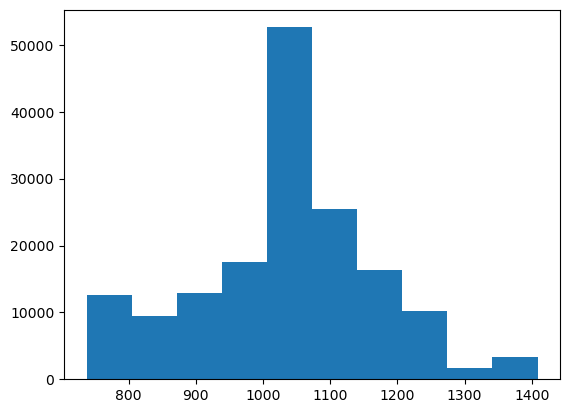

In [66]:
#With those updated, let's take a look at our distribution of precipitation
plt.hist(trees_climate_updated['norm_prcp_mm_total'])
plt.show()

In [67]:
#how about abnormally low values below the min of our more complete values?
unique_updated[(unique_updated['reports_#'] < 300) & (unique_updated['norm_prcp_mm_total'] < 939.0)].sort_values('station_id')

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
85172,WA-KG-200,290,302,WA-KG-272,669.3,8.0,3.020192,0.000000,812.004087,8.000000
118688,WA-KG-200,290,302,WA-KG-204,669.3,8.0,2.874006,0.000000,805.096789,8.000000
145247,WA-KG-200,290,302,WA-KG-258,669.3,8.0,3.252000,0.108571,822.957000,13.130000
118498,WA-KG-243,3,3,WA-KG-204,0.0,48.0,2.874006,0.000000,780.292661,48.000000
134094,WA-KG-243,3,3,WA-KG-72,0.0,48.0,2.894101,0.143258,785.748455,86.894663
142273,WA-KG-243,3,3,WA-KG-258,0.0,48.0,3.252000,0.108571,882.918000,77.477143
100868,WA-KG-286,31,32,WA-KG-272,181.6,0.0,3.020192,0.000000,935.893029,0.000000
66035,WA-KG-294,215,224,WA-KG-239,421.9,0.0,2.983333,0.000000,737.387500,0.000000
123358,WA-KG-299,61,90,WA-KG-33,369.3,0.0,2.726301,0.284932,931.599658,0.000000
59193,WA-KG-79,224,233,WA-KG-239,638.8,13.0,2.983333,0.000000,934.150000,13.000000


In [68]:
#I don't want to mess with the data too much, but I did a 25% adjustment (75% adj factor) on my imputation based on the assumption that days are more likely to be tracked when there is rain, than when there isn't.
#But this breaks down for station WA-KG-243 which had 3 days and 0 rainfall tracked. For this one I will simply imput new values

target_station = 'WA-KG-243' #set this up for locating which records to update
prcp_median = trees_climate_updated['norm_prcp_mm_total'].median() #using median here since each location will have data and this will normalize it better

trees_climate_updated.loc[trees_climate_updated.station_id == target_station, 'norm_prcp_mm_total'] = prcp_median


In [69]:
#validate that stuck
trees_climate_updated[trees_climate_updated['station_id'] == target_station][['station_id','norm_prcp_mm_total']].value_counts()

station_id  norm_prcp_mm_total
WA-KG-243   1062.352644           8778
dtype: int64

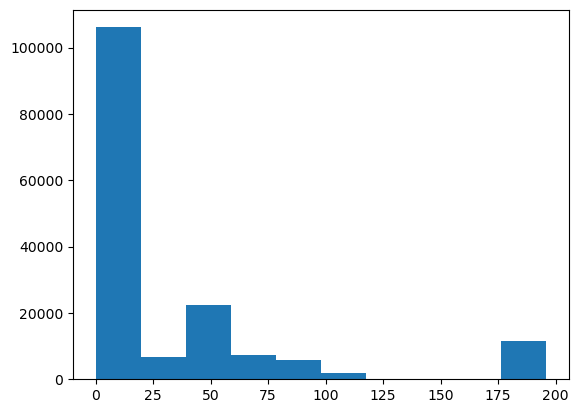

In [70]:
#Last distribution check - this time on our snowfall
plt.hist(trees_climate_updated['norm_snow_mm_total'])
plt.show()


In [71]:
#We'll go through the same process as with our prcp
unique_updated[(unique_updated['reports_#'] < 400) & (unique_updated['norm_snow_mm_total'] > 100)].sort_values('station_id') #filter down to view records

,station_id,reports_#,adj_reports,station_id_norm,prcp_mm_22,daily_snow_mm,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
15402,WA-KG-225,356,365,WA-KG-225,1117.6,196.0,3.061918,0.536986,1117.6,196.0
121528,WA-KG-33,353,365,WA-KG-33,995.1,104.0,2.726301,0.284932,995.1,104.0


This is actually directly from our reported data. Doing some quick searches online at these location and verifying the data pull I can't find any proof this is incorrect. I will leave for now atleast.

#### 3.4.5 Clean-up Columns

With my imputed values in place, I can drop remaining columns we'll no longer need.

In [72]:
trees_climate_updated.shape

(162077, 28)

In [73]:
#drop all created specifically from our imputing process
trees_climate_updated.drop(columns=['prcp_mm_22','daily_snow_mm','norm_prcp_daily_avg','norm_snow_daily_avg','nearest_complete','station_id_norm','norm_station_name'],inplace=True)

trees_climate_updated.shape

(162077, 21)

#### 3.4.5 Check Correlation/Covariance

/var/folders/_z/9zltq2bj1dz1k05g4mtz4gq00000gn/T/ipykernel_2073/4034685785.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = trees_climate_updated.drop(columns=['lat_trees','long_trees','lat_prcp','long_prcp']).corr() #do not include lat & lon


[]

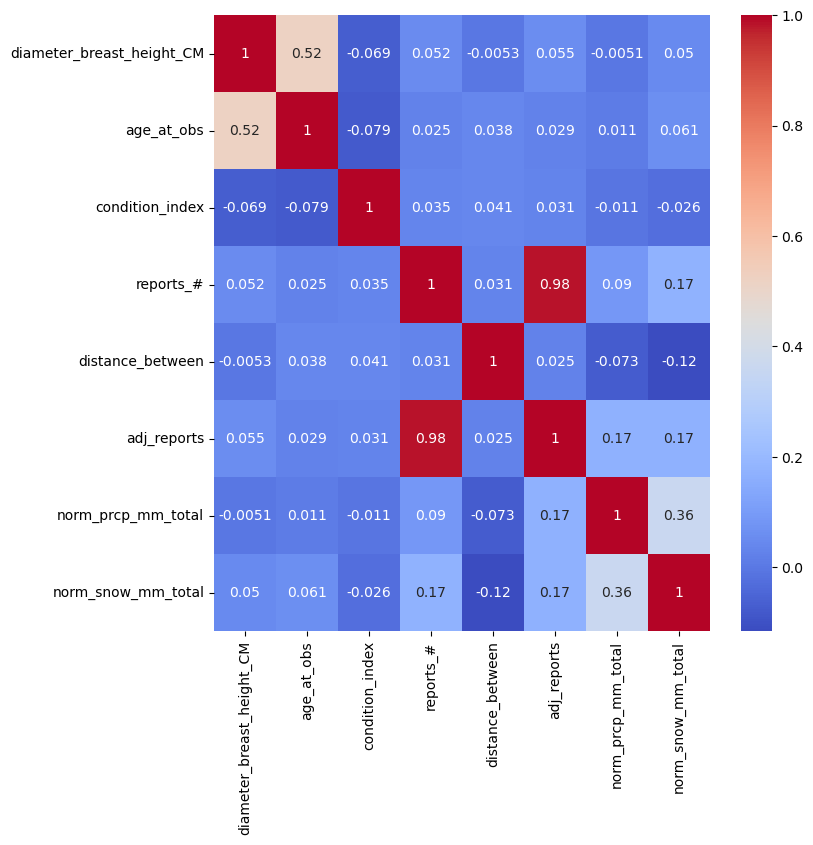

In [74]:
#create variable with values
corrMatrix = trees_climate_updated.drop(columns=['lat_trees','long_trees','lat_prcp','long_prcp']).corr() #do not include lat & lon

fig, ax = plt.subplots(figsize=(8,8))

#plot with seaborn
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')

plt.plot()

**Observations:**
\
Well, not a lot of correlation there. Ouch. I'll continue to move forward and plan on using some categorical fields and some non-linear regressions. So we'll see what we can come up with, but this was not totally unexpected when we pivoted from aiming for using this data to predict surface temperature or air quality to having my target feature come out of the trees data itself.
\
\
It does flow with what I would expect that there is some correlation between age and diameter, that makes me feel better about the quality of data itself. Same with some slight correlation between precipitation and snow fall. # of reports and adjusted reports are expectedlty very correlated, and if we do find some use for one, I'll drop the other in the next step. But I think calculating a daily average either reported or off of the imputed annual total will be my move.
\
\
On to the next!

### 3.5 Save Data

In [75]:
# save trees data to a new csv
filepath = '../data/data_outputs/seattle_trees_explored.csv'
trees_climate_updated.to_csv(filepath, index=False)